# Logistic Regression

In this notebook we will implement logistic regression from scratch using a single neuron and gradient descent. We will then use logistic regression to predict the probability the repairs on a bike can be completed "outpatient".

## 0. Imports and Data

In [1]:
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

# Import a nice function for plotting decision boudaries
from mlxtend.plotting import plot_decision_regions

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In [9]:
df = pd.read_csv("../../data/rb_tx_data.csv")
df = df.set_index("TransactionID")

df = df.replace(np.nan,0)



df = df.loc[(df['TotalCost']>0) & 
            (df['RepairCost']>0) &
            (df['TurnaroundTime']>0) &
            (df['TurnaroundTime']<38) 
            ]

X = df.loc[:,['RepairCost', 'Queue']].values
y = np.where(df['DayCreated'] == df['DayCompleted'], 0, 1)

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.25, random_state = 42)

## 1. Input Feature Motivation

Inuitively, there is a positive correlation between total repair costs and the number of distinct days between when a bike is taken in and when repairs are completed. Additionally, as bikes are worked on in a queue, we expect that queue size also correlates with repair time. 

Of primary interest to Rice Bikes is when a bike's repairs can be completed within the same day, as this reduces the overhead of the storing the bike inside our limited space over multiple days. Colloqiuially we refer to these as "outpatient" transactions. 

To motivate this investigation, let us check how both repair costs and queue length compare to whole day repair times.

In [10]:
repair_costs = []
for days in range(14):
    repair_costs.append(df.loc[ df['DayCompleted']- df['DayCreated']== days, 'RepairCost'])

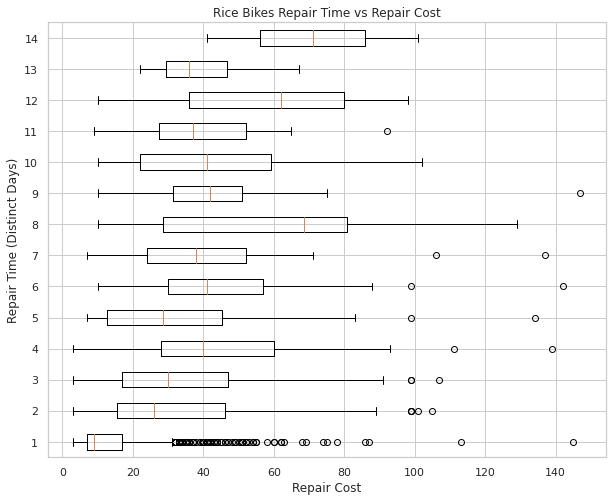

In [11]:
sns.set(style="whitegrid")
plt.figure(figsize=(10,8))
plt.boxplot(repair_costs, vert=False);
plt.title("Rice Bikes Repair Time vs Repair Cost")
plt.ylabel("Repair Time (Distinct Days)")
plt.xlabel("Repair Cost")
plt.show()

There is a demonstrated positive correlation between transaction repair cost and whole day repair times. Note the high number of datapoints far from the repair cost mean for transactions with low repair times.

In [14]:
backlogs = []
for day in range(14):
    backlogs.append(df.loc[ df['DayCompleted']- df['DayCreated']== day, 'Queue'])

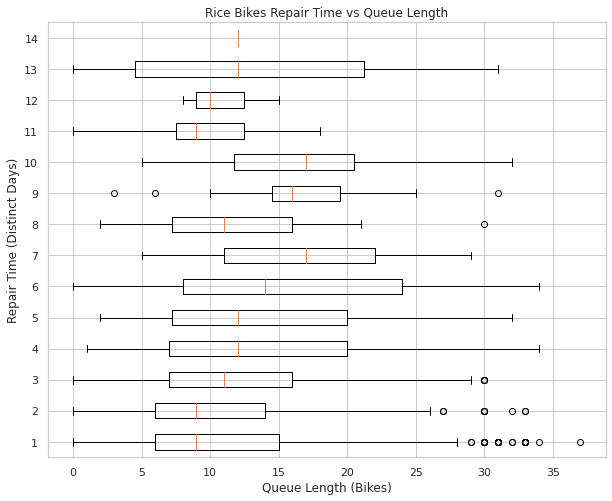

In [15]:
sns.set(style="whitegrid")
plt.figure(figsize=(10,8))
plt.boxplot(backlogs, vert=False);
plt.title("Rice Bikes Repair Time vs Queue Length")
plt.ylabel("Repair Time (Distinct Days)")
plt.xlabel("Queue Length (Bikes)")
plt.show()

There is a demonstrated positive correlation between queue length and repair time for repair times of less than a week, however the effect tapers off by the second week of repairs. Speculatively, if a bike is taking longer than 1 week, it is likely that the reason for the delay is specific to that transaction as opposed to reflected in the queue.

## 2. Logistic Regression Model 1 (RepairCosts, Queue)

Next, we can use logistic regression to predict same day repair completion from repair costs and queue length.

In [17]:
class SingleNeuron(object):


    def __init__(self, activation_function, cost_function):
        self.activation_function = activation_function # activation function
        self.cost_function = cost_function
        self.scaler = StandardScaler()

    def train(self, X,y, alpha= 0.001, epochs = 50):
        # intiailize a weight for each feature as well as a singular bias
        self.w_ = np.random.rand(1 + X.shape[1]) 
        self.errors_ = []
        N = X.shape[0] # sample count

        self.scaler.fit(X)
        _X = self.scaler.transform(X)
        

        for e in range(epochs):
            y_hat = self.predict(X) # unscaled
            errors = y_hat - y # one error per sample per featrue
            self.w_[:-1] -= alpha * (errors @ _X) # dot each error w/ corresponding sample
            self.w_[-1]  -= alpha * (errors.sum())
            epoch_cost = self.cost_function(y_hat, y).sum()
            self.errors_.append(epoch_cost/N)


            #errors = 0
            #for xi, target in zip(X, y):
            #    #print(f"{xi = }")
            #    y_hat = self.predict(xi)
            #    error = (y_hat - target)
            #    self.w_[:-1] -= alpha*(error)*xi
            #    self.w_[-1] -= alpha*(error)
            #    #errors += .5*((error)**2)
            #    errors += self.cost_function(y_hat, target)
            #    #print(f"{y_hat = }")
            #    #print(f"{target = }")
            #    #print(f"{self.cost_function(y_hat, target) = }")
            #self.errors_.append(errors/N)
        return self

    def predict(self, X):
        _X = self.scaler.transform(X)

        #preactivation = X @ self.w_[:-1] + self.w_[-1]
        preactivation = np.dot(_X, self.w_[:-1]) + self.w_[-1] # z
        return self.activation_function(preactivation)


    def plot_cost_function(self):
        fig, axs = plt.subplots(figsize = (10, 8))
        axs.plot(range(1, len(self.errors_) + 1), 
                self.errors_,
                label = "Cost function")
        axs.set_xlabel("epochs", fontsize = 15)
        axs.set_ylabel("Cost", fontsize = 15)
        axs.legend(fontsize = 15)
        axs.set_title("Cost Calculated after Epoch During Training", fontsize = 18)
        plt.show()

    def plot_decision_boundary(self, X, y, xlabel="x", ylabel="y"):
        plt.figure(figsize = (10, 8))
        plot_decision_regions(X, y, clf = self)
        plt.title("Neuron Decision Boundary", fontsize = 18)
        plt.xlabel(xlabel, fontsize = 15)
        plt.ylabel(ylabel, fontsize = 15)
        plt.show()

In [18]:
def sigmoid(z):
    """
    The activation function for a logistic regression neuron.
    """
    return 1.0/(1.0 + np.exp(-z))

def cross_entropy_loss(y_hat, y):
    """
    The cost function for a logistic regression neuron.
    """
    return - y*np.log(y_hat) - (1 - y)*np.log(1 - y_hat) #if ( y_hat != 1 and y_hat != 0 ) else 0

In [25]:
# Train a logisitic regression model
node1 = SingleNeuron(activation_function= sigmoid, cost_function=cross_entropy_loss)
node1.train(X_train,y_train, alpha=0.001, epochs=100);
node1.w_ # the linear coefficients describing the resulting logistic decision boundary hyperplane

array([ 1.76070249,  0.4950259 , -0.7332176 ])

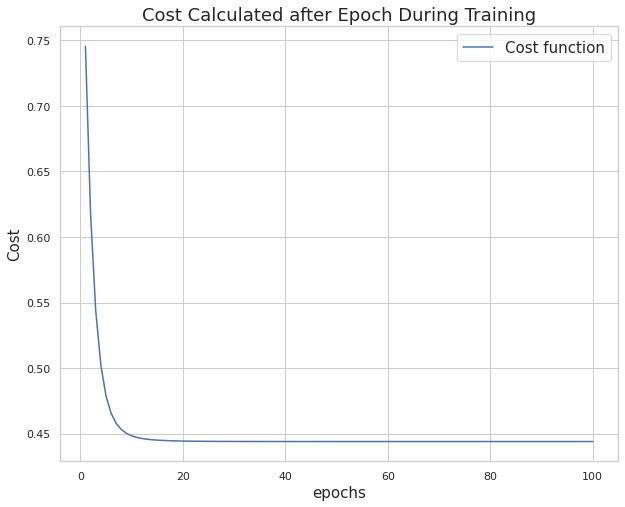

In [20]:
node.plot_cost_function()

In [26]:
classification_error = (np.rint(node1.predict(X_test)) != y_test).astype(int)
print(f"Classification Error = {sum(classification_error)/ len(y_test)}")

Classification Error = 0.24817518248175183


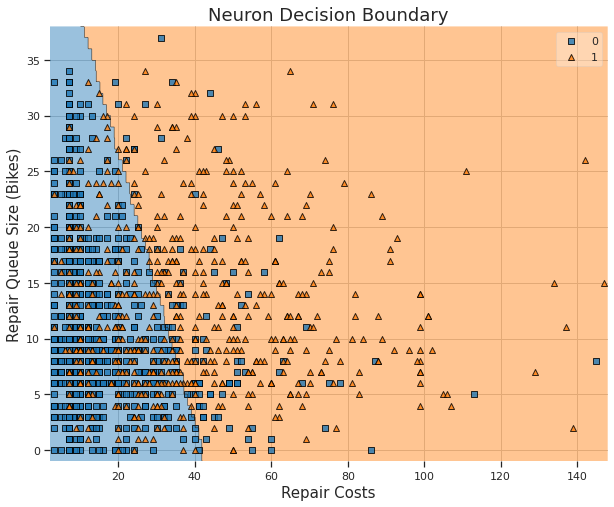

In [27]:
node1.plot_decision_boundary(X, y, xlabel="Repair Costs", ylabel="Repair Queue Size (Bikes)")


Visualizing the decision boundary, we can see that both of the projected effects are observed in the resulting model. In particular, as either repair costs increase or queue length increase, so does the estimated probability that a bike is taken inpatient.

## 3. Logistic Regression Model 2 (All Repairs)

As noted previously, the effect of queue length on repair time appeared to be dominated by features unqiue to that specific transaction past a certain point. Furthermore, in the box plot of repair time vs repair costs, we noted numerous outliers from the mean repair costs for bikes with short repair times. This suggests that not all repair costs are created equal. To investimate this further, we will train a second logistic regression model utilizing all of specific types repairs attached to each transaction 

The last 70 columns of the given dataset represent all of the repairs offered by Rice Bikes.

In [28]:
df.columns[14:]

Index(['RearFlatRepair', 'AdjustRimBrake', 'InstallingLever',
       'InstallBrakePads', 'InstallBrake', 'InstallBrakeCable',
       'HeadsetAdjustment', 'AdjustDiskBrake', 'HeadsetOverhaul',
       'WrapHandlebars', 'InstallGrips', 'InstallHandlebars',
       'AdjustBottomBracket', 'InstallBottomBracket', 'InstalStem',
       'InstallShifter', 'OverhaulBottomBracket', 'InstallShifterCable',
       'InstallDerailleur', 'MajorClean', 'AdjustFrontDerailleur',
       'AdjustRearDerailleur', 'AlignDerailleurHanger', 'InstallRearRack',
       'ReplacePedals(Set)', 'ReplacePedal(Single)', 'ReplaceChain',
       'InstallFreewheel', 'ReplaceCrankset', 'InstallBasket', 'FlatRepair',
       'InstallCassette', 'ReplaceOneTube', 'ReplaceOneTire', 'InstallOneTire',
       'HubOverhaul(Front)', 'CleanAndLubeChain', 'HubOverhaul(Rear)',
       'CoasterHubOverhaul', 'Level1TuneUp', 'AdjustHubBearings(Front)',
       'Level2TuneUp', 'Level3TuneUp', 'AdjustHubBearings(Rear)',
       'MinorAdjustment', '

In [43]:
 
#X = df.loc[:, ['RepairCost', 'Backlog'] ].values
X = df.loc[:, df.columns[14:]].values
y = np.where(df['DayCreated'] == df['DayCompleted'], 0, 1)

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.25, random_state = 42)

X_train.shape

(1233, 70)

In [44]:
node2 = SingleNeuron(sigmoid, cross_entropy_loss)
node2.train(X_train,y_train, alpha=0.001, epochs=100);

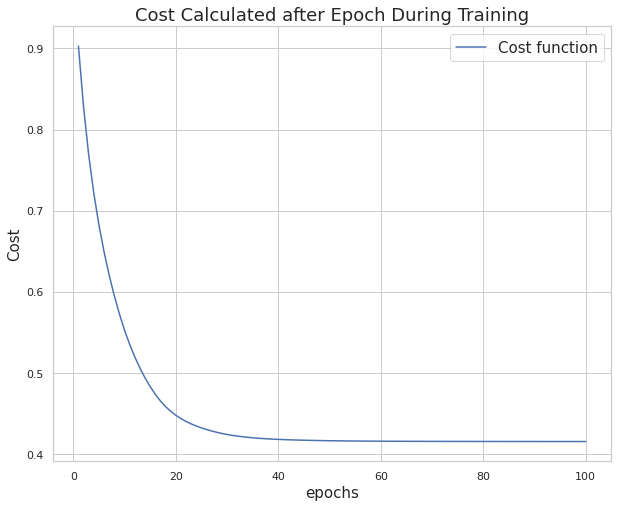

In [49]:
node2.plot_cost_function()
plt.show()

In [46]:
classification_error = (np.rint(node2.predict(X_test)) != y_test).astype(int)
print(f"Classification Error = {sum(classification_error)/ len(y_test)}")

Classification Error = 0.24574209245742093


By including all repair data, we were able to obtain a lower classification error on the test set.